# Imports and spark config

In [1]:
import os

# Set SPARK_HOME
os.environ["SPARK_HOME"] = r"C:/Spark/spark-3.5.0-bin-hadoop3"

# Set PYTHONPATH
spark_home = os.environ.get("SPARK_HOME", "")
if spark_home:
    python_path = os.path.join(spark_home, "python")
    py4j_zip = os.path.join(spark_home, "python", "lib", "py4j-0.10.9.7-src.zip")
    os.environ["PYTHONPATH"] = f"{python_path};{py4j_zip};{os.environ.get('PYTHONPATH', '')}"

# Set PYSPARK_PYTHON
os.environ["PYSPARK_PYTHON"] = r"C:\Users\Vincenzo\AppData\Local\Programs\Python\Python38\python.exe"
print(os.environ.get('PYSPARK_PYTHON'))

# Set PATH
if spark_home:
    os.environ["PATH"] = f"{python_path};{os.path.join(spark_home, 'bin')};{os.environ.get('PATH', '')}"

C:\Users\Vincenzo\AppData\Local\Programs\Python\Python38\python.exe


In [2]:
import findspark
findspark.init()

import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [3]:
spark = SparkSession.builder.appName("spark").config("spark.driver.memory", "24g").getOrCreate()
spark

In [4]:
# spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
# spark.conf.set('spark.sql.repl.eagerEval.maxNumRows', 5)

In [5]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

# Data preparation

In [6]:
df = spark.read.parquet(r"c:\Users\Vincenzo\PROJECTS\DDAM_data\brewery\brewery_data_complete_extended.parquet")
type(df)

pyspark.sql.dataframe.DataFrame

In [7]:
df.printSchema()
rows = df.count()
cols = len(df.columns)

print(f'Dimension of the Dataframe is: {(rows,cols)}')
df.show(5)

root
 |-- Batch_ID: long (nullable = true)
 |-- Brew_Date: string (nullable = true)
 |-- Beer_Style: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Fermentation_Time: long (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: long (nullable = true)
 |-- Color: long (nullable = true)
 |-- Ingredient_Ratio: string (nullable = true)
 |-- Volume_Produced: long (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fermentation: double (nullable = true)
 |-- Loss_During_Bottling_Kegging: double (nullable = true)

Dimension of the Dataframe is: (10000000, 20)
+--------+-------------------+----------+----+------------+--

In [8]:
sample = df.sample(fraction=0.1, seed=42) #.drop("Batch_ID")

In [9]:
summary_stats = sample.toPandas().describe()
rounded_describe = np.round(summary_stats, 2)
rounded_describe

,Batch_ID,Fermentation_Time,Temperature,pH_Level,Gravity,Alcohol_Content,Bitterness,Color,Volume_Produced,Total_Sales,Quality_Score,Brewhouse_Efficiency,Loss_During_Brewing,Loss_During_Fermentation,Loss_During_Bottling_Kegging
count,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00
mean,5004909.19,14.50,20.00,5.00,1.06,5.25,39.52,12.00,2749.48,10491.48,8.00,79.99,3.00,3.00,3.00
std,2887164.29,2.87,2.89,0.29,0.01,0.43,11.54,4.32,1298.31,5486.58,1.15,5.78,1.15,1.16,1.15
min,5.00,10.00,15.00,4.50,1.03,4.50,20.00,5.00,500.00,1000.00,6.00,70.00,1.00,1.00,1.00
25%,2502862.50,12.00,17.50,4.75,1.04,4.88,30.00,8.00,1624.00,5747.89,7.00,74.98,2.00,2.00,2.00
50%,5008192.00,15.00,20.00,5.00,1.06,5.25,40.00,12.00,2751.00,10486.75,8.00,79.99,3.00,3.00,3.00
75%,7506431.50,17.00,22.51,5.25,1.07,5.63,50.00,16.00,3874.00,15240.40,9.00,85.00,4.00,4.00,4.00
max,9999993.00,19.00,25.00,5.50,1.08,6.00,59.00,19.00,4999.00,19999.97,10.00,90.00,5.00,5.00,5.00


In [10]:
from pyspark.sql.functions import split, col

# Split the ratio_column into three parts based on the colon delimiter
split_col = split(col("Ingredient_Ratio"), ":")

# Create three separate columns for water, grains, and hops
sample = sample.withColumn("water", split_col.getItem(0).cast("double"))
sample = sample.withColumn("grains", split_col.getItem(1).cast("double"))
sample = sample.withColumn("hops", split_col.getItem(2).cast("double"))
sample = sample.drop("Ingredient_Ratio")
# Now you have three separate columns for water, grains, and hops with their respective values

In [11]:
# Define a new column with the USD per liter ratio
sample = sample.withColumn("USD_per_Liter", F.col("Total_Sales") / F.col("Volume_Produced").cast("double"))

In [12]:
from pyspark.sql.types import StringType

# Identify numerical and non-numerical columns
numerical_cols = [col_name for col_name, data_type in sample.dtypes if data_type != 'string']
categorical_cols = [col_name for col_name, data_type in sample.dtypes if data_type == 'string']

print(f'Numerical columns: {numerical_cols}')
print(f'Categorical columns: {categorical_cols}')

Numerical columns: ['Batch_ID', 'Fermentation_Time', 'Temperature', 'pH_Level', 'Gravity', 'Alcohol_Content', 'Bitterness', 'Color', 'Volume_Produced', 'Total_Sales', 'Quality_Score', 'Brewhouse_Efficiency', 'Loss_During_Brewing', 'Loss_During_Fermentation', 'Loss_During_Bottling_Kegging', 'water', 'grains', 'hops', 'USD_per_Liter']
Categorical columns: ['Brew_Date', 'Beer_Style', 'SKU', 'Location']


In [13]:
# distinct_num_counts = {}

# for col in numerical_cols:
#     distinct_count = sample.select(col).distinct().count()
#     distinct_num_counts[col] = distinct_count

#     print(f"- {col} - {distinct_count} distinct values")

In [18]:
# distinct_cat_counts = {}

# for col in categorical_cols:
#     distinct_count = sample.select(col).distinct().count()
#     distinct_cat_counts[col] = distinct_count

#     print(f"- {col} - {distinct_count} distinct values")

## Low-values discrete variables analysis

### Functions

In [14]:
# functions

from pyspark.sql.functions import when, col
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, dense_rank, when
from pyspark.sql.window import Window

def ordinal_encode_pyspark(df, input_col, output_col):
    """ Ordinal encodes a column within a PySpark DataFrame

    Args:
        df (pyspark.sql.DataFrame): The input Spark DataFrame.
        input_col (str): Name of the column to be encoded. Defaults to "Bitterness".
        output_col (str): Name for the new ordinal encoded column. Defaults to "Bitterness_ordinal".
    
    Returns:
        pyspark.sql.DataFrame: The Spark DataFrame with the ordinal encoded column.
    """

    window = Window.orderBy(input_col) 
    return df.withColumn(output_col, dense_rank().over(window)) \
             .withColumn(output_col, when(col(input_col).isNull(), 0).otherwise(col(output_col))) \
             #.drop(input_col)
             
def check_distinct_values(df, feature_col):
    """  
    Prints the distinct values of a feature in a PySpark DataFrame.

    Args:
        df (pyspark.sql.DataFrame): The PySpark DataFrame.
        feature_col (str): The name of the feature column.
    """

    distinct_values = df.select(feature_col).distinct().collect()

    print(f"Distinct values in '{feature_col}':")
    for row in distinct_values:
        print(row[feature_col]) 

    # functions

def one_hot_encode_column(df, input_col, output_col_prefix="encoded"):
    """ One-hot encodes a specified categorical column, drops intermediary columns,
        and allows for specifying the prefix of the output columns.

    Args:
        df (pyspark.sql.DataFrame): Input DataFrame.
        input_col (str): The name of the column containing categorical data.
        output_col_prefix (str): Prefix for the generated one-hot encoded column names.

    Returns:
        pyspark.sql.DataFrame: DataFrame with the one-hot encoded column(s) and 
                               intermediary columns removed.
    """

    indexer = StringIndexer(inputCol=input_col, outputCol=input_col + "_index")
    encoder = OneHotEncoder(inputCol=input_col + "_index", outputCol=output_col_prefix + input_col + "features")
    assembler = VectorAssembler(inputCols=[input_col + "_index"], outputCol="features") 

    pipeline = Pipeline(stages=[indexer, assembler, encoder])
    transformed_df = pipeline.fit(df).transform(df)

    # Drop unnecessary columns
    drop_cols = [input_col, input_col + "_index", "features"]
    return transformed_df.drop(*drop_cols)  # Dynamic column dropping
def discretize_and_encode(df, input_col="fermentation_time"):
    """ Discretizes a feature into bins, one-hot encodes the bins, and preserves the original column

    Args:
        df (pyspark.sql.DataFrame): Input DataFrame
        input_col (str): Name of the column to be discretized and encoded

    Returns:
        pyspark.sql.DataFrame:  DataFrame with new discretization and encoded columns
    """

    df = df.withColumn(input_col + "_bin", 
                       when((col(input_col) >= 10) & (col(input_col) <= 13), "Short")
                       .when((col(input_col) >= 14) & (col(input_col) <= 16), "Medium")
                       .otherwise("Long"))
    
    return one_hot_encode_column(df, input_col=input_col + "_bin") 

### Color

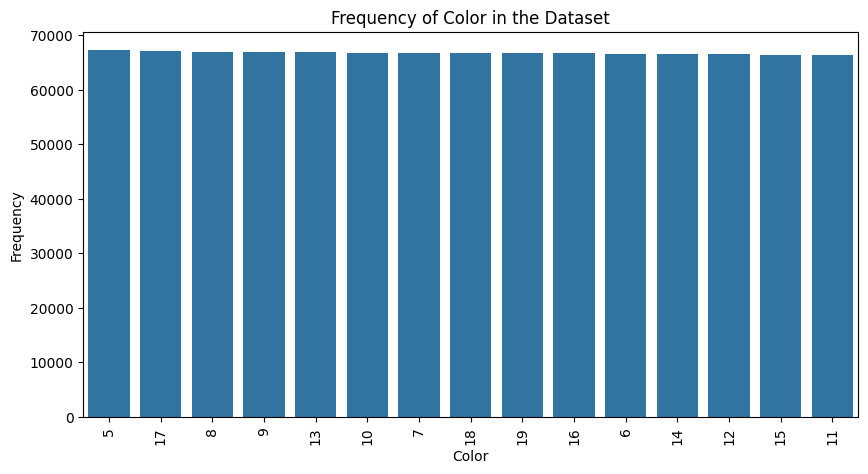

In [20]:
color_frequency = sample.groupBy("Color").count().toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=color_frequency, x="Color", y="count", order=color_frequency.sort_values('count', ascending=False)["Color"])
plt.title('Frequency of Color in the Dataset')
plt.xlabel('Color')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [21]:
# sample = ordinal_encode_pyspark(sample, "Color", "Color_ordinal")
# sample.show(5)

# summary_stats = sample.select("Color_ordinal").toPandas().describe()
# rounded_describe = np.round(summary_stats, 2)
# rounded_describe

In [22]:
# color_frequency = sample.groupBy("Color_ordinal").count().toPandas()

# plt.figure(figsize=(10, 5))
# sns.barplot(data=color_frequency, x="Color_ordinal", y="count", order=color_frequency.sort_values('Color_ordinal', ascending=True)["Color_ordinal"])
# plt.title('Frequency of Color in the Dataset')
# plt.xlabel('Color')
# plt.ylabel('Frequency')
# plt.xticks(rotation=90)
# plt.show()


### Bitterness

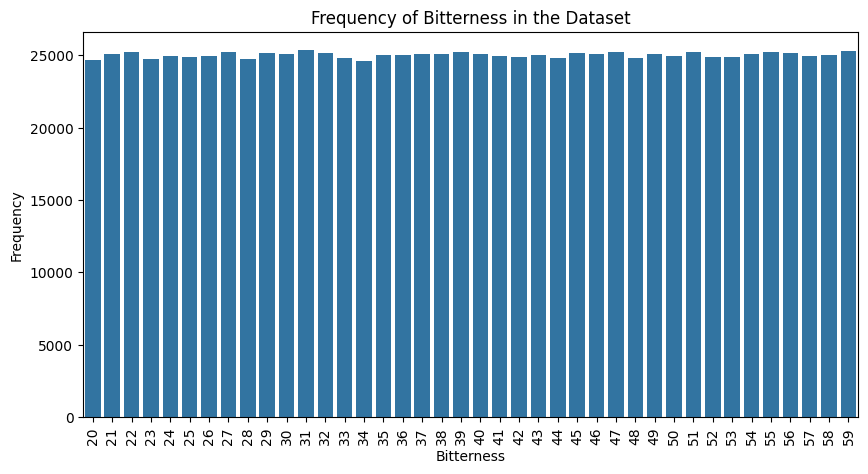

In [23]:
Bitterness_frequency = sample.groupBy("Bitterness").count().toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=Bitterness_frequency, x="Bitterness", y="count", order=Bitterness_frequency.sort_values('Bitterness', ascending=True)["Bitterness"])
plt.title('Frequency of Bitterness in the Dataset')
plt.xlabel('Bitterness')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


In [24]:
# sample = ordinal_encode_pyspark(sample, "Bitterness", "Bitterness_ordinal") 
# sample.show(5)

# summary_stats = sample.select("Bitterness_ordinal").toPandas().describe()
# rounded_describe = np.round(summary_stats, 2)
# rounded_describe

In [25]:
# Bitterness_ordinal_frequency = sample.groupBy("Bitterness_ordinal").count().toPandas()

# plt.figure(figsize=(10, 5))
# sns.barplot(data=Bitterness_ordinal_frequency, x="Bitterness_ordinal", y="count", order=Bitterness_ordinal_frequency.sort_values('Bitterness_ordinal', ascending=True)["Bitterness_ordinal"])
# plt.title('Frequency of Bitterness_ordinal in the Dataset')
# plt.xlabel('Bitterness_ordinal')
# plt.ylabel('Frequency')
# plt.xticks(rotation=90)
# plt.show()


### Grains

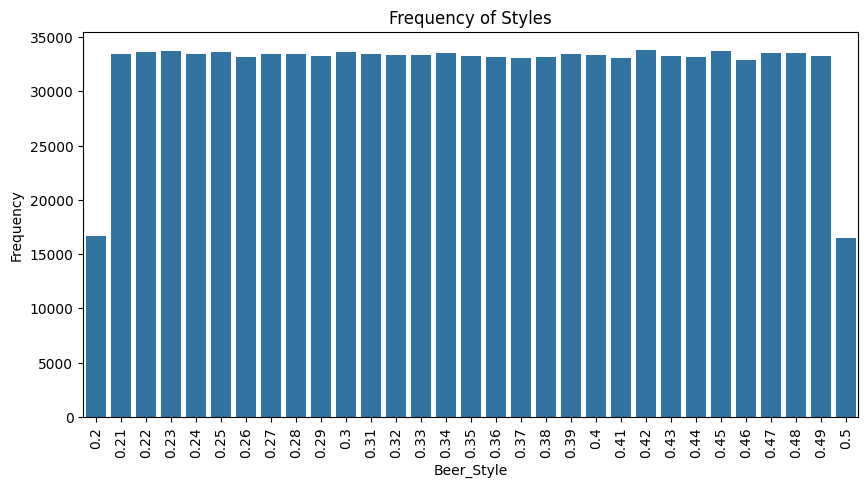

In [26]:
grains_frequency = sample.groupBy("grains").count().toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=grains_frequency, x="grains", y="count", order=grains_frequency.sort_values('grains', ascending=True)["grains"])
plt.title('Frequency of Styles')
plt.xlabel('Beer_Style')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

### Hops

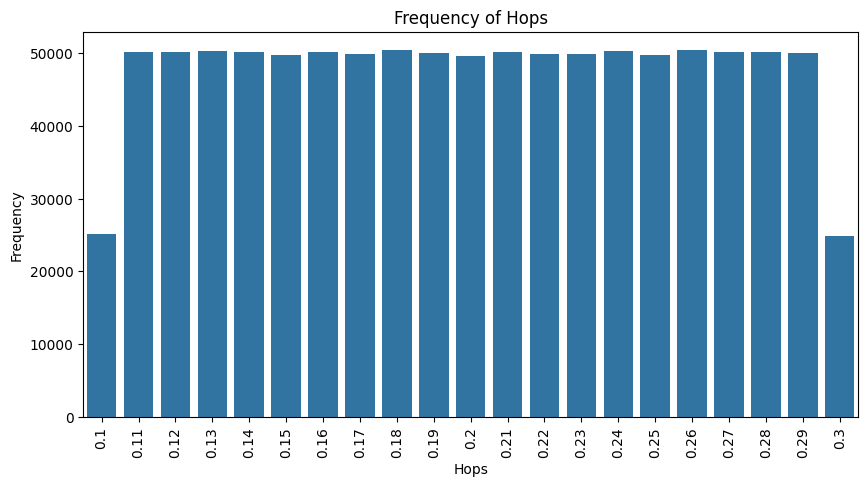

In [27]:
hops_frequency = sample.groupBy("hops").count().toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=hops_frequency, x="hops", y="count", order=hops_frequency.sort_values('hops', ascending=True)["hops"])
plt.title('Frequency of Hops')
plt.xlabel('Hops')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

### Fermentation time

In [15]:
sample = discretize_and_encode(sample)
sample.select("encodedfermentation_time_binfeatures").show(5)

+------------------------------------+
|encodedfermentation_time_binfeatures|
+------------------------------------+
|                       (2,[0],[1.0])|
|                       (2,[0],[1.0])|
|                           (2,[],[])|
|                           (2,[],[])|
|                       (2,[0],[1.0])|
+------------------------------------+
only showing top 5 rows



In [16]:
# sample.select("encodedfermentation_time_binfeatures").toPandas().describe()

## Categorical variables analysis

### Beer style

In [17]:
sample = one_hot_encode_column(sample, "Beer_Style")
sample.select("encodedBeer_Stylefeatures").show(5)

+-------------------------+
|encodedBeer_Stylefeatures|
+-------------------------+
|            (7,[6],[1.0])|
|            (7,[0],[1.0])|
|                (7,[],[])|
|            (7,[6],[1.0])|
|            (7,[2],[1.0])|
+-------------------------+
only showing top 5 rows



In [18]:
# sample.select("encodedBeer_Stylefeatures").toPandas().describe()

### SKU

In [19]:
sample = one_hot_encode_column(sample, "SKU")
sample.select("encodedSKUfeatures").show(5)

+------------------+
|encodedSKUfeatures|
+------------------+
|     (3,[1],[1.0])|
|     (3,[0],[1.0])|
|         (3,[],[])|
|     (3,[2],[1.0])|
|     (3,[2],[1.0])|
+------------------+
only showing top 5 rows



In [20]:
# sample.select("encodedSKUfeatures").toPandas().describe()

### Location

In [21]:
sample = one_hot_encode_column(sample, "Location")
sample.select("encodedLocationfeatures").show(5)

+-----------------------+
|encodedLocationfeatures|
+-----------------------+
|          (9,[5],[1.0])|
|              (9,[],[])|
|          (9,[4],[1.0])|
|          (9,[0],[1.0])|
|          (9,[6],[1.0])|
+-----------------------+
only showing top 5 rows



In [22]:
# sample.select("encodedLocationfeatures").toPandas().describe()

In [23]:
sample.printSchema()

root
 |-- Batch_ID: long (nullable = true)
 |-- Brew_Date: string (nullable = true)
 |-- Fermentation_Time: long (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: long (nullable = true)
 |-- Color: long (nullable = true)
 |-- Volume_Produced: long (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fermentation: double (nullable = true)
 |-- Loss_During_Bottling_Kegging: double (nullable = true)
 |-- water: double (nullable = true)
 |-- grains: double (nullable = true)
 |-- hops: double (nullable = true)
 |-- USD_per_Liter: double (nullable = true)
 |-- encodedfermentation_time_binfeatures: vector (nullable = true)
 |-- encodedBeer_Stylefeatures: vector (nullable 

# Data Exploration

## plots

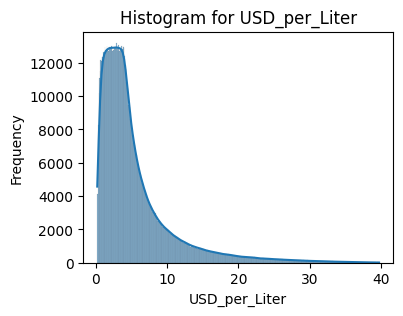

In [37]:
plt.figure(figsize=(4, 3))
sns.histplot(data=sample.select("USD_per_Liter").toPandas(), x="USD_per_Liter", kde=True)
plt.title(f'Histogram for USD_per_Liter')
plt.xlabel("USD_per_Liter")
plt.ylabel('Frequency')
plt.show()

## correlation

In [ ]:
corr_sample = sample.drop("water", "Batch_ID","encodedBeer_Stylefeatures", "encodedSKUfeatures", "encodedLocationfeatures")
corr_sample = corr_sample.drop("Brew_Date", "encodedfermentation_time_binfeatures")

corr_sample.printSchema()

In [ ]:
corr_sample.printSchema()

In [ ]:
corr = corr_sample.toPandas().corr(method='pearson')
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
corr = corr_sample.toPandas().corr(method='spearman')
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
corr = corr_sample.toPandas().corr(method='kendall')
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
plt.title('Correlation Matrix')
plt.show()

# MachineLearning

In [26]:
sample.printSchema()

root
 |-- Batch_ID: long (nullable = true)
 |-- Brew_Date: string (nullable = true)
 |-- Fermentation_Time: long (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: long (nullable = true)
 |-- Color: long (nullable = true)
 |-- Volume_Produced: long (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fermentation: double (nullable = true)
 |-- Loss_During_Bottling_Kegging: double (nullable = true)
 |-- water: double (nullable = true)
 |-- grains: double (nullable = true)
 |-- hops: double (nullable = true)
 |-- USD_per_Liter: double (nullable = true)
 |-- encodedfermentation_time_binfeatures: vector (nullable = true)
 |-- encodedBeer_Stylefeatures: vector (nullable 

In [27]:
sample.show(5)

+--------+-------------------+-----------------+------------------+-----------------+------------------+-----------------+----------+-----+---------------+------------------+-----------------+--------------------+-------------------+------------------------+----------------------------+-----+------+----+-------------------+------------------------------------+-------------------------+------------------+-----------------------+
|Batch_ID|          Brew_Date|Fermentation_Time|       Temperature|         pH_Level|           Gravity|  Alcohol_Content|Bitterness|Color|Volume_Produced|       Total_Sales|    Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|water|grains|hops|      USD_per_Liter|encodedfermentation_time_binfeatures|encodedBeer_Stylefeatures|encodedSKUfeatures|encodedLocationfeatures|
+--------+-------------------+-----------------+------------------+-----------------+------------------+-----------------+----------+---

## Alcol content

### regression

In [28]:
sample.select("Alcohol_content").toPandas().describe()

,Alcohol_content
count,1.001591e+06
mean,5.250250e+00
std,4.329737e-01
min,4.500002e+00
25%,4.875388e+00
50%,5.250748e+00
75%,5.625394e+00
max,5.999999e+00


In [29]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

# Feature Preparation
features_cols = ["Fermentation_Time" ,"Temperature", "pH_Level" , "Gravity", 
                 "Bitterness", "Color", "grains", "hops", "encodedBeer_Stylefeatures"]

regr_alc_sample = sample.alias("regr_alc_sample")

assembler = VectorAssembler(inputCols=features_cols, outputCol="features")
df_transformed = assembler.transform(regr_alc_sample)

# Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="Alcohol_Content")
lr_model = lr.fit(df_transformed)

# Evaluation
predictions = lr_model.transform(df_transformed)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Alcohol_Content", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE): %f" % rmse) 

# Model Coefficients (Feature Influence)
print(lr_model.coefficients) 


Root Mean Squared Error (RMSE): 0.432971
[2.6960514322627025e-05,-0.0002481610979711845,-0.00017465242763680796,-0.011016513853791439,5.779484314346475e-05,1.6857623637812647e-05,0.00017642787952471082,-0.005658811330289977,-0.002150377919696565,-0.0032904768661720873,-0.0034471454217839797,-0.0030279322789531493,-0.001654340705193461,-0.0014432891231469017,-0.0014335642563218626]


Interpreting Results

    RMSE: Evaluate the RMSE score. A lower value implies better average accuracy in predicting alcohol content using your features.
    
    Coefficients: Examine the sign (+/-) and magnitude of each feature's coefficient. These tell you:
        Positive Coefficient: Increases in this feature tend to associate with higher 'Alcohol_Content'.
        Negative Coefficient: Increases in this feature tend to associate with lower 'Alcohol_Content'.
        Magnitude: Larger the value (ignoring the sign), stronger the apparent impact of said feature, linearly speaking.


Interpreting the Results

    RMSE (0.432971): The context is crucial here. To judge whether this RMSE is "good" or "bad," consider the natural range of 'Alcohol_Content' values in your dataset.
        As a crude example, suppose 'Alcohol_Content' typically varies between 4% and 10%. Then a 0.43 error might be tolerable.
        If these alcohol values instead range from 4% to 5%, this same error becomes highly significant.

Analyzing Coefficients

Here's a breakdown of how to draw inferences from the model's coefficients:

    Sign:
        Positive coefficients suggest those features tend to be associated with higher alcohol content in your dataset.
        Negative coefficients imply an association with lower alcohol content.

    Magnitude: The larger the absolute value of a coefficient, the stronger its apparent linear influence on 'Alcohol_Content' is, all else being equal.

    Sparseness: Notice several coefficients (especially those for ingredient amounts) are very close to zero. This might mean these have practically negligible linear impact within the range of values encountered in your dataset.

Considerations

    Statistical Significance: This simple linear regression doesn't provide measures of statistical significance for each coefficient. Techniques exist to estimate confidence intervals, making more robust assertions about feature effect strength.

### trees

udf explanation site: https://sparkbyexamples.com/pyspark/pyspark-udf-user-defined-function/

In [44]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

features_cols = ["Fermentation_Time" ,"Temperature", "pH_Level" , "Gravity", 
                 "Bitterness", "Color", "grains", "hops", "encodedBeer_Stylefeatures"]

tree_alc_sample = sample.alias("tree_alc_sample")

# Binarizing 'Alcohol_Content'
from pyspark.sql.functions import udf

def binarize(alcohol_value):
    if alcohol_value  <= 5.0:
        return "Low"
    elif alcohol_value <= 5.5:
        return "Medium"
    else:
        return "High"

binarize_udf = udf(binarize, StringType())
tree_alc_sample = tree_alc_sample.withColumn("Alcohol_Bin", binarize_udf("Alcohol_Content"))

# Encoding 'Alcohol_Bin' this solves the stringtype issue for the onehotencoder
tree_alc_sample = tree_alc_sample.withColumn("Alcohol_Bin", 
                        when(col("Alcohol_Bin") == "Low", 0). 
                        when(col("Alcohol_Bin") == "Medium", 1).
                        otherwise(2)) 

# Feature Preparation
assembler = VectorAssembler(inputCols=features_cols, outputCol="features")  
df_transformed = assembler.transform(tree_alc_sample)

# Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="Alcohol_Bin")
dt_model = dt.fit(df_transformed)

# Predictions
predictions = dt_model.transform(df_transformed)

# Evaluation (For Classification)
evaluator = MulticlassClassificationEvaluator(labelCol="Alcohol_Bin", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: %f" % accuracy) 

# Visualization (may need external libraries depending on your setup)
print(dt_model.toDebugString) 


+--------------------------------------------------------------------------------------------------------------+
|features                                                                                                      |
+--------------------------------------------------------------------------------------------------------------+
|[13.0,21.60546968919005,4.507213419450749,1.0415809900303394,38.0,9.0,0.45,0.26,0.0,0.0,0.0,0.0,0.0,0.0,1.0]  |
|[11.0,22.903972245938505,5.473563790227288,1.0373730025224546,44.0,10.0,0.31,0.21,1.0,0.0,0.0,0.0,0.0,0.0,0.0]|
|(15,[0,1,2,3,4,5,6,7],[15.0,17.785713321899884,5.318024913782187,1.0687167841553329,23.0,5.0,0.23,0.16])      |
|[16.0,24.869178082298525,4.849521382421813,1.0451318832513898,40.0,10.0,0.42,0.27,0.0,0.0,0.0,0.0,0.0,0.0,1.0]|
|[12.0,22.629383129373903,4.77639650569921,1.0305953857694026,38.0,19.0,0.26,0.11,0.0,0.0,1.0,0.0,0.0,0.0,0.0] |
|[19.0,22.16253755912976,4.936910740031992,1.0362644599452784,21.0,13.0,0.42,0.28,0.0,0.0,1.0,0.

# Closing statements